In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
import scipy.misc

In [20]:
def img_read(img):
    return mpimg.imread(img)

def plot_gray(img):
    plt.imshow(img, cmap='gray')
    
def grayscale(img, bgr_flag):
    if not bgr_flag:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def darkend_image(img, gamma = 1.0):
    # Use gamma correction to darken an image
    # https://stackoverflow.com/questions/33322488/how-to-change-image-illumination-in-opencv-python/41061351
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 
            for i in np.arange(0, 256)]).astype("uint8")
    
    return cv2.LUT(img, table)

def color_mask(img, low, high):
    return cv2.inRange(img, low, high)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low, high):
    return cv2.Canny(img, low, high)

def region_of_interest(img, points):
    mask = np.zeros_like(img)
    
    if img.shape[2]:
        channel_count = img.shape[2]
        ignore_mask = (255, )* chennel_count
    else:
        ignore_mask = 255
    
    cv2.fillPoly(mask, points, ignore_mask)
    region = cv2.bitwise_and(img, mask)
    return region

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return img

def hough_lines(img, ro=1, theta=np.pi/180, treshold=20, min_line_len=20, max_line_gap=300):
    # Use probabilistic hough transform
    
    return cv2.HoughLinesP(img, ro, theta, treshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)




In [21]:
def display_all_images(img_list, labels=[], cols=2, fig_size=(15, 15)):
    if len(labels) > 0:
        assert(len(img_list) == len(labels))
    assert(len(img_list) > 0)
    cmap = None
    tot = len(img_list)
    rows = tot / cols
    plt.figure(figsize=fig_size)
    for i in range(tot):
        plt.subplot(rows, cols, i+1)
        if len(img_list[i].shape) == 2:
            cmap = 'gray'
        if len(labels) > 0:
            plt.title(labels[i])
        plt.imshow(img_list[i], cmap=cmap)
        
    plt.tight_layout()
    plt.show()


In [22]:
path = "./sdc-data/sdc-test-images"
test_images_names = os.listdir(path)

img_list = [img_read(path + '/' + name) for name in test_images_names]
#display_all_images(img_list, test_images_names)
unprocessed_images = np.copy(img_list)

gray_images = [grayscale(img, 0) for img in img_list]
#display_all_images(gray_images, test_images_names)

darkened_images = [darkend_image(img, 0.5) for img in gray_images]
#display_all_images(darkened_images, test_images_names)


In [23]:
# White and yellow mask to isolate lane markings
white_mask = [color_mask(to_hls(img), np.array([0, 200, 0]), np.array([200,255,255])) for img in img_list]
yellow_mask = [color_mask(to_hls(img), np.array([10, 0, 100]), np.array([40, 255, 255])) for img in img_list]

images_after_mask = []

for i in range(len(img_list)):
    mask = cv2.bitwise_or(white_mask[i], yellow_mask[i])
    images_after_mask.append(cv2.bitwise_and(darkened_images[i], darkened_images[i], mask = mask))

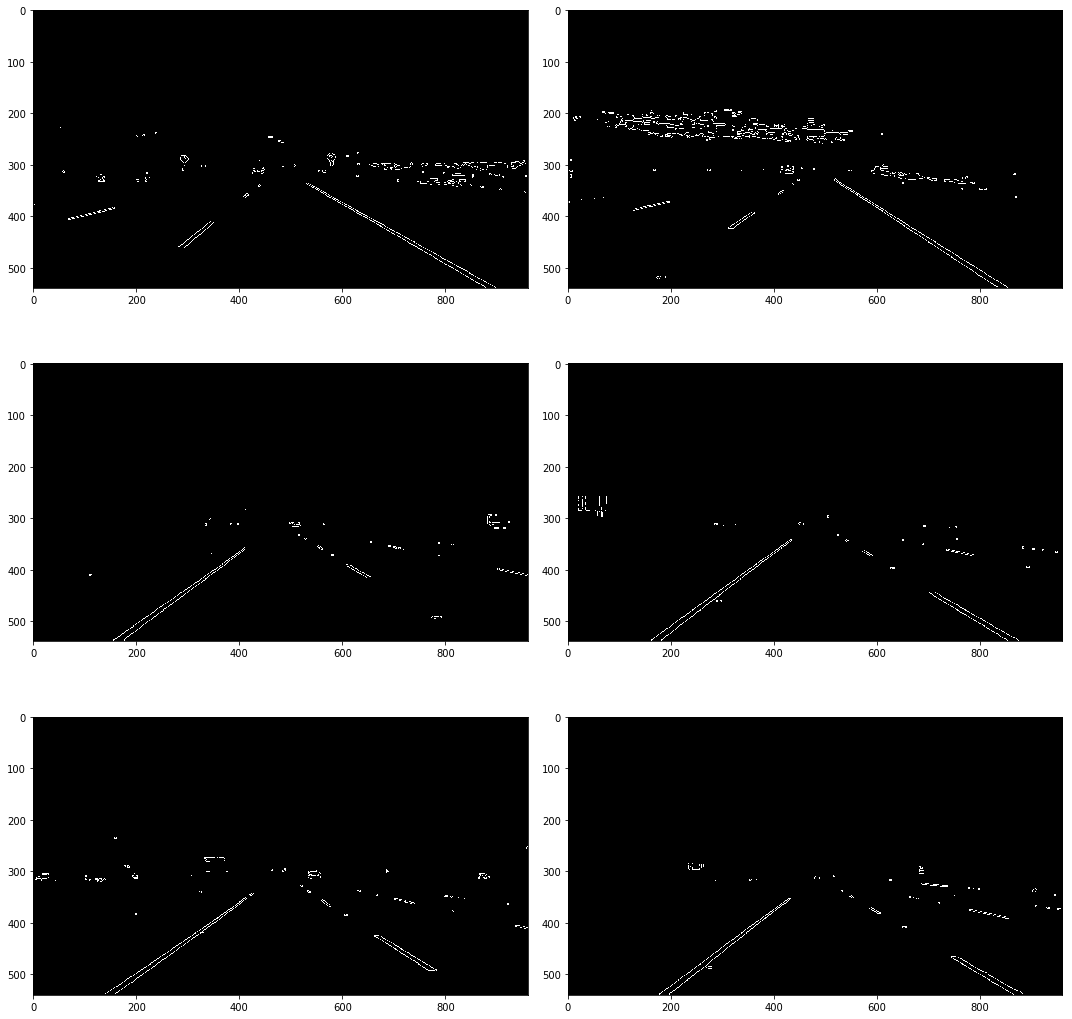

In [24]:
blured_images = [gaussian_blur(img, kernel_size=5) for img in images_after_mask]

canny_images = [canny(img, 70, 140) for img in blured_images]
display_all_images(canny_images)

In [25]:
# Not sure how this works, look it up later
aoi_images = []

def get_aoi(img):
    rows, cols = img.shape[:2]
    mask = np.zeros_like(img)
    
    left_bottom = [cols * 0.1, rows]
    right_bottom = [cols * 0.95, rows]
    left_top = [cols * 0.4, rows * 0.6]
    right_top = [cols * 0.6, rows * 0.6]
    
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    
    if len(mask.shape) == 2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255, ) * mask.shape[2])
    return cv2.bitwise_and(img, mask)
    
for img in canny_images:        
    aoi_images.append(get_aoi(img))

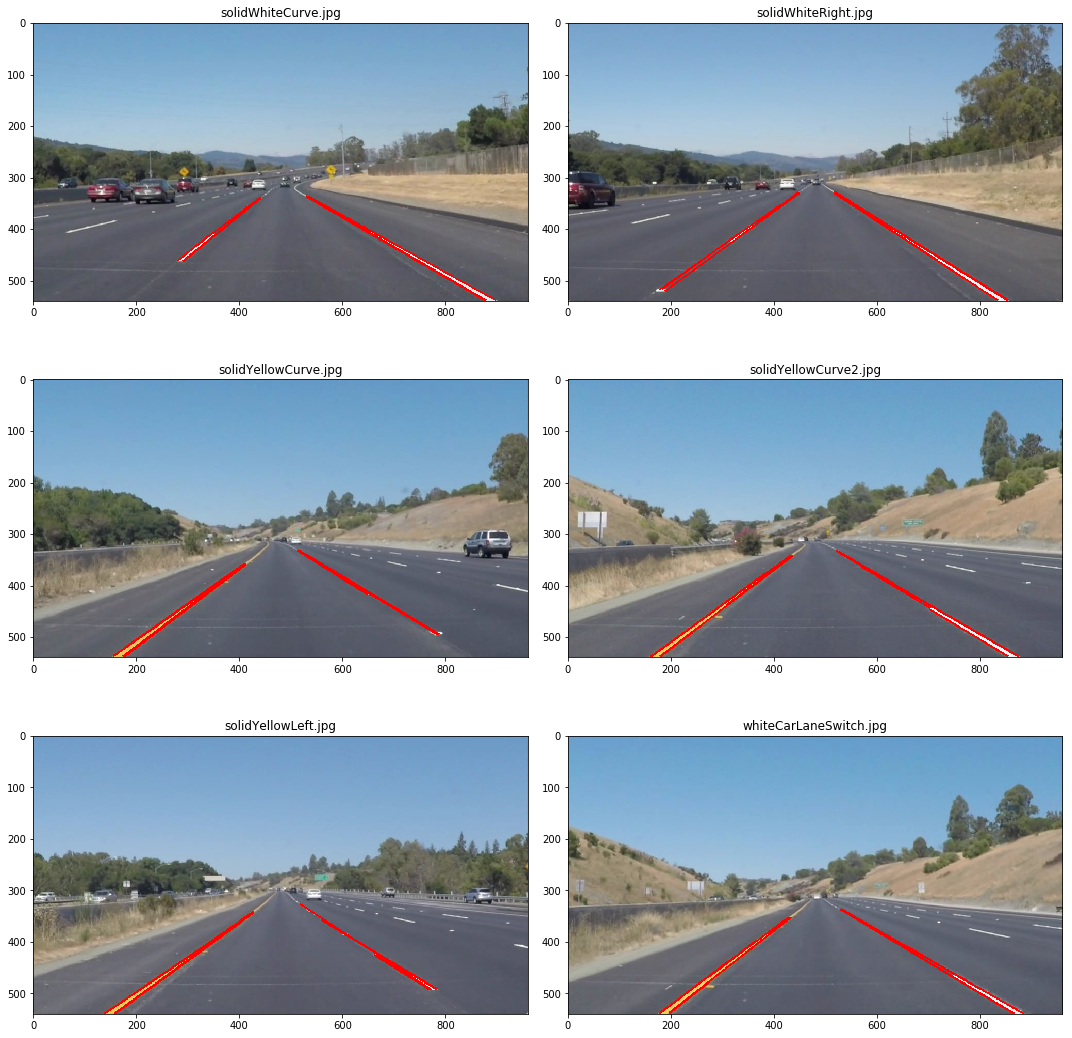

In [26]:
hough_images = []
lines = []

for img in aoi_images:
    lines.append(hough_lines(img))

for img, line in zip(unprocessed_images, lines):
    hough_images.append(draw_lines(img, line))
    
display_all_images(hough_images, test_images_names)

In [27]:
def get_line_length(line):
    for x1,y1,x2,y2 in line:
        return np.sqrt((y2-y1)**2 + (x2-x1)**2)

def get_line_slope_intecept(line):
    for x1,y1,x2,y2 in line:
        if x1-x2 == 0:
            return math.inf, 0
        
    slope = (y2-y1)/(x2-x1)
    intercept = y1 - slope * x1
    
    return slope, intercept

def get_lines_slope_intecept(lines):
    left_lines = []
    right_lines = []
    left_lengths = []
    right_lengths = []
    
    for line in lines:
        slope, intercept = get_line_slope_intecept(line)
        
        if slope == math.inf:
            # hirizontal line
            continue 
        line_len = get_line_length(line)
        if slope < 0: # left line
            left_lines.append((slope, intercept))
            left_lengths.append(line_len)
        else: # right line
            right_lengths.append(line_len)
            right_lines.append((slope, intercept))
            
    left_avg = np.dot(left_lengths, left_lines)/np.sum(left_lengths) if len(left_lengths) > 0 else None
    right_avg = np.dot(right_lengths, right_lines)/np.sum(right_lengths) if len(right_lengths) > 0 else None
    
    return left_avg, right_avg


def convert_slope_intercept_to_line(y1, y2 , line):
    if line is None:
        return None
    
    slope, intercept = line
    x1 = int((y1- intercept)/slope)
    y1 = int(y1)
    x2 = int((y2- intercept)/slope)
    y2 = int(y2)
    return((x1, y1),(x2, y2))

def get_lane_lines(img, lines):
    left_avg, right_avg = get_lines_slope_intecept(lines)
    
    y1 = img.shape[0]
    y2 = img.shape[0] * 0.6
    
    left_lane = convert_slope_intercept_to_line(y1, y2, left_avg)
    right_lane = convert_slope_intercept_to_line(y1, y2, right_avg)
    return left_lane, right_lane

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def draw_weighted_lines(img, lines, color=[255, 0, 0], thickness=2, alpha = 1.0, beta = 0.95, gamma= 0):
    mask_img = np.zeros_like(img)
    for line in lines:
        if line is not None:
            cv2.line(mask_img, *line, color, thickness)            
    return weighted_img(mask_img, img, alpha, beta, gamma)

lane_lines_imgs =[]

for img, line in zip(img_list, lines):
    left_lane, right_lane = get_lane_lines(img, line)
    lane_lines_imgs.append(draw_weighted_lines(img, [left_lane, right_lane], thickness= 15))
    

In [28]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
def process_frame(img, calc_mean=False, **kwargs):
    
    original_image = np.copy(img)
    
    gray_img = grayscale(img, 0)
    
    darkend_img = darkend_image(gray_img, 0.5)
    
    white_mask = color_mask(to_hls(img), np.array([0, 200, 0]), np.array([200,255,255]))
    yellow_mask = color_mask(to_hls(img), np.array([10, 0, 100]), np.array([40, 255, 255]))
    
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    colored_img = cv2.bitwise_and(darkend_img, darkend_img, mask = mask)
    
    blurred_img = gaussian_blur(colored_img, kernel_size=5)
    
    canny_img = canny(blurred_img, 70, 140)
    
    aoi_img = get_aoi(canny_img)
    
    hough_lines_list = hough_lines(aoi_img)
    hough_img = draw_lines(original_image, hough_lines_list)
    
    left_lane, right_lane = get_lane_lines(original_image, hough_lines_list)
    
    
    result = draw_weighted_lines(original_image, [left_lane, right_lane], thickness=10)
    
    return result, left_lane, right_lane

In [30]:
from collections import deque

class LaneMemory:
    def __init__(self, max_entries=50):
        self.max_entries = max_entries
        self.left_lanes = deque(maxlen=self.max_entries)
        self.right_lanes = deque(maxlen=self.max_entries)
        
    def process(self, img):
        result, left_lane , right_lane = process_frame(img, calc_mean=True, left_mem= self.left_lanes, right_mem = self.right_lanes)
        self.left_lanes.append(left_lane)
        self.right_lanes.append(right_lane)
        return result

In [32]:
white_output = "sdc-data/video-output/challenge.mp4"

laneMemory = LaneMemory()

clip1 = VideoFileClip("sdc-data/sdc-test-videos/challenge.mp4")

white_clip = clip1.fl_image(laneMemory.process)
%time white_clip.write_videofile(white_output, audio=False)

OSError: [WinError 6] The handle is invalid

In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))